# Final Project

In [142]:
# import libraries (notice that we have included some new libraries that we will be using in this lab)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import scipy.stats as stat
import statsmodels.api as sm
import datetime
from numbers import Number

In [143]:
stationName = "Vancouver Harbour" # Vancouver Harbour # Tofino

van_slev_file_name = 'data/VanHarbourSeaLevelData.csv'
van_temperature_file_name = 'data/VanHarbourTempData.csv'
tofino_slev_file_name = 'data/TofinoSeaLevelData.csv'
tofino_temperature_file_name = 'data/TofinoTempData.csv'

In [144]:
# Make dataframe for each day for the period of 1940-2021 for Vancouver Harbour and Tofino

start_date = "1940-01-01"
end_date = "2021-12-31"

date_range = pd.date_range(start=start_date, end=end_date, freq='D')
df_SOB_van = pd.DataFrame(date_range, columns=['Date'])
df_SOB_tofino = pd.DataFrame(date_range, columns=['Date'])


In [145]:
# Read in the Vancouver Harbour Data 
df_van_slev = pd.read_csv(van_slev_file_name, sep=',', parse_dates=['Date'])
df_van_slev = df_van_slev.set_index('Date')

df_van_temp = pd.read_csv(van_temperature_file_name, sep=',', parse_dates=['Date'])
df_van_temp = df_van_temp.set_index('Date')
# drop columns other than date and MeanTemp
df_van_temp = df_van_temp.drop(columns=['Unnamed: 0', 'Year', 'Month', 'Day', 'MaxTemp', 'MaxTempFlag',
       'MinTemp', 'MinTempFlag', 'MeanTempFlag', 'HeatDegDays',
       'HeatDegDaysFlag', 'CoolDegDays', 'CoolDegDaysFlag'])


In [146]:
# Add the data to the SOB dataframe if the date matches
df_SOB_van = df_SOB_van.merge(df_van_slev, how='left', on='Date')
df_SOB_van = df_SOB_van.merge(df_van_temp, how='left', on='Date')

df_SOB_tofino = df_SOB_tofino.merge(df_van_slev, how='left', on='Date')
df_SOB_tofino = df_SOB_tofino.merge(df_van_temp, how='left', on='Date')

In [147]:
# Plot the time series for the data
def plot_daily_time_series(df, x_name, y_name, title, xlabel, ylabel):
    plt.figure(figsize=(15, 5))
    plt.plot(df[x_name], df[y_name], '-', color='black' )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Plot monthly time series
def plot_monthly_time_series(df, x_name, y_name, title, xlabel, ylabel):
    df_monthly = df.groupby(pd.Grouper(key=x_name, freq='M')).mean()
    plt.figure(figsize=(15, 5))
    plt.plot(df_monthly.index, df_monthly[y_name], '-', color='black' )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Plot Yearly time series
def plot_yearly_time_series(df, x_name, y_name, title, xlabel, ylabel):
    df_yearly = df.groupby(pd.Grouper(key=x_name, freq='Y')).mean()
    plt.figure(figsize=(15, 5))
    plt.plot(df_yearly.index, df_yearly[y_name], '-', color='black' )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

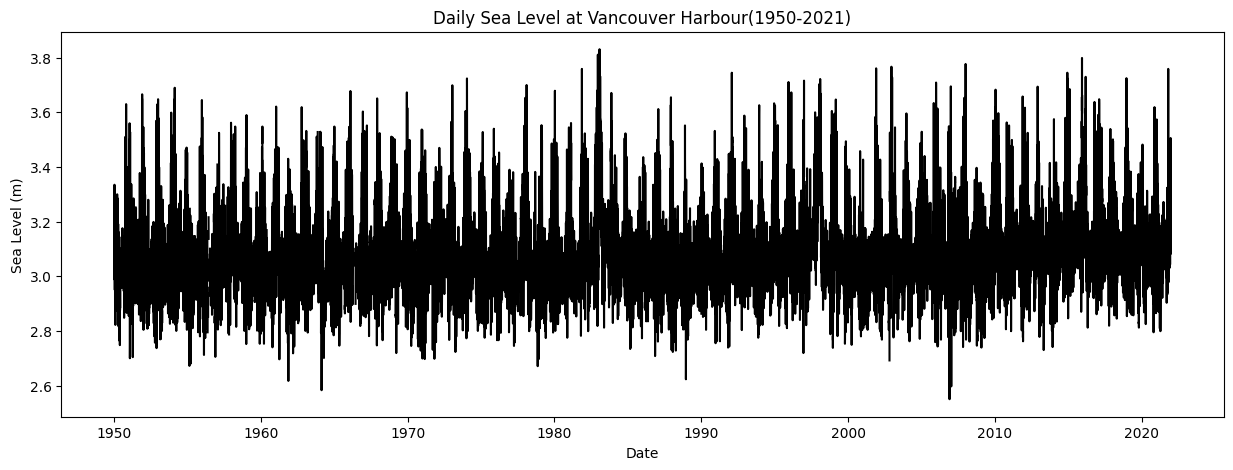

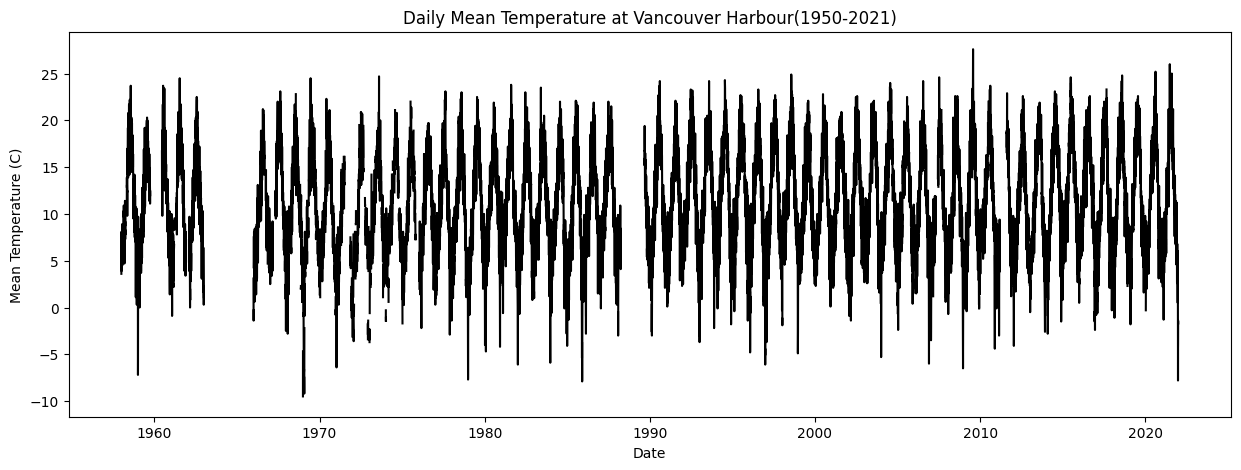

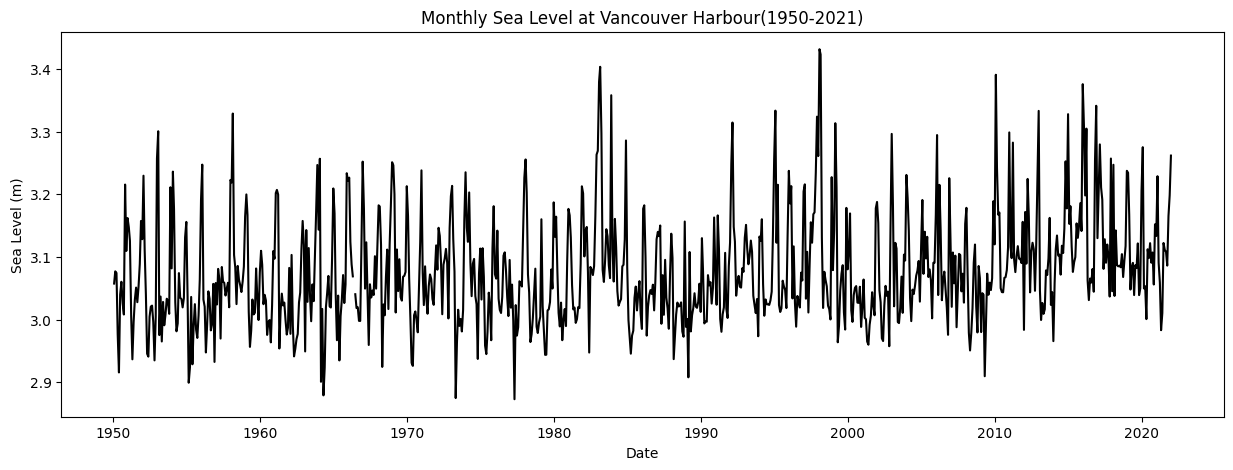

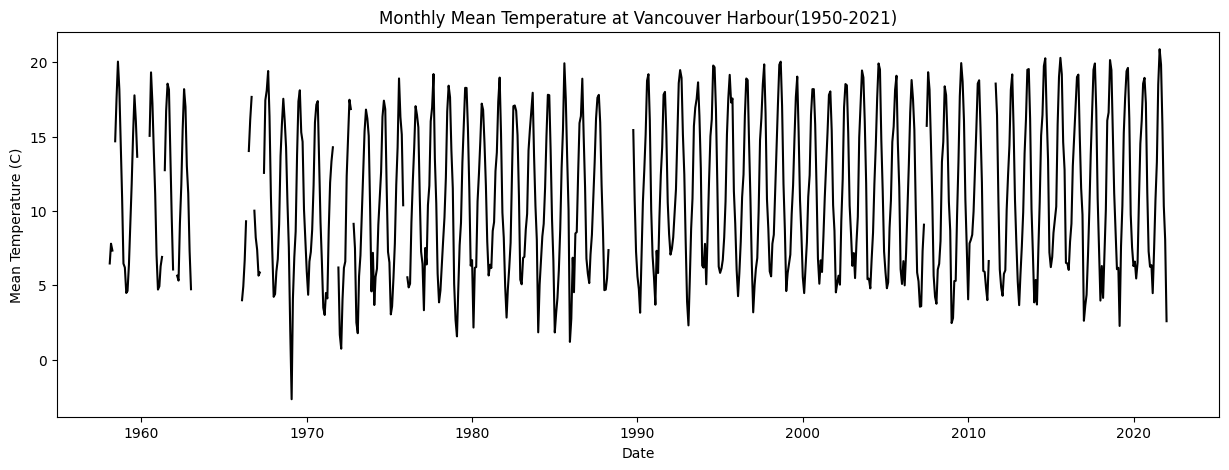

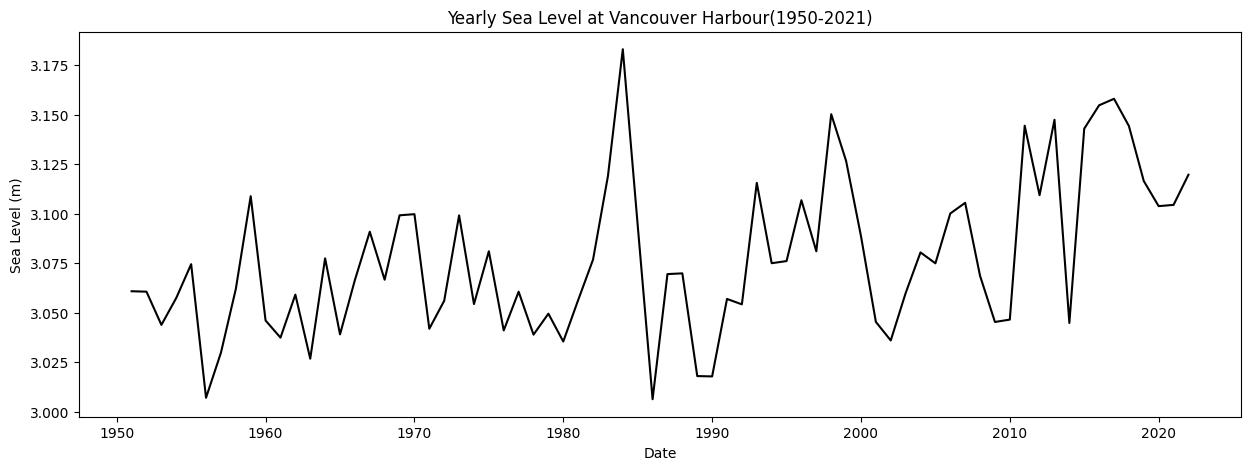

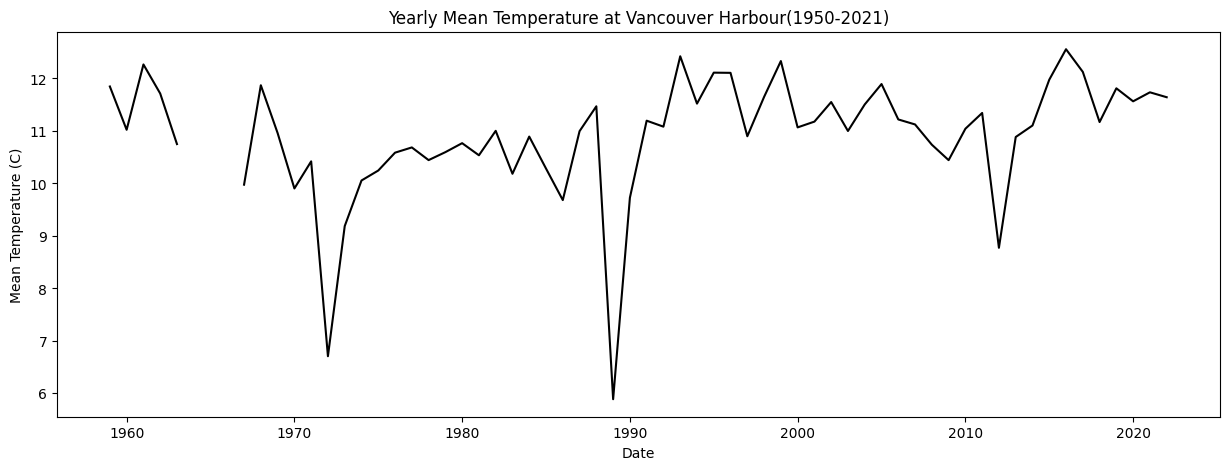

In [148]:
plot_daily_time_series(df_SOB_van, 'Date', 'sealevel', 'Daily Sea Level at ' + stationName + '(1950-2021)', 'Date', 'Sea Level (m)')
plot_daily_time_series(df_SOB_van, 'Date', 'MeanTemp', 'Daily Mean Temperature at ' + stationName + '(1950-2021)', 'Date', 'Mean Temperature (C)')
plot_monthly_time_series(df_SOB_van, 'Date', 'sealevel', 'Monthly Sea Level at ' + stationName + '(1950-2021)', 'Date', 'Sea Level (m)')
plot_monthly_time_series(df_SOB_van, 'Date', 'MeanTemp', 'Monthly Mean Temperature at ' + stationName + '(1950-2021)', 'Date', 'Mean Temperature (C)')
plot_yearly_time_series(df_SOB_van, 'Date', 'sealevel', 'Yearly Sea Level at ' + stationName + '(1950-2021)', 'Date', 'Sea Level (m)')
plot_yearly_time_series(df_SOB_van, 'Date', 'MeanTemp', 'Yearly Mean Temperature at ' + stationName + '(1950-2021)', 'Date', 'Mean Temperature (C)')

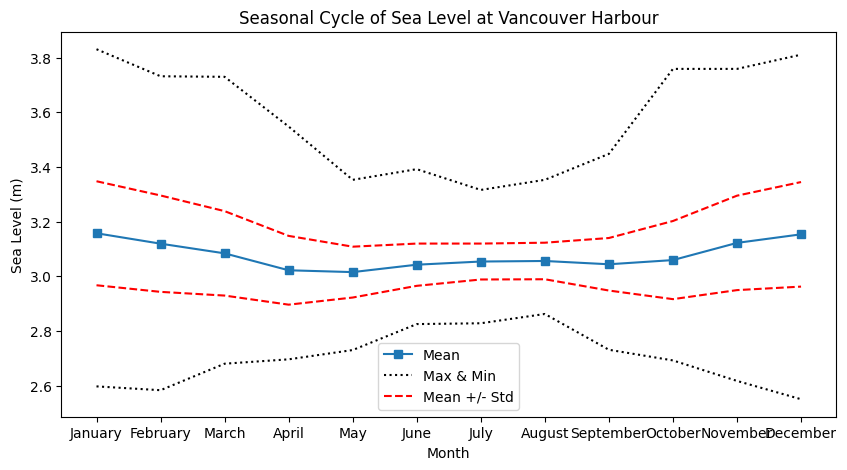

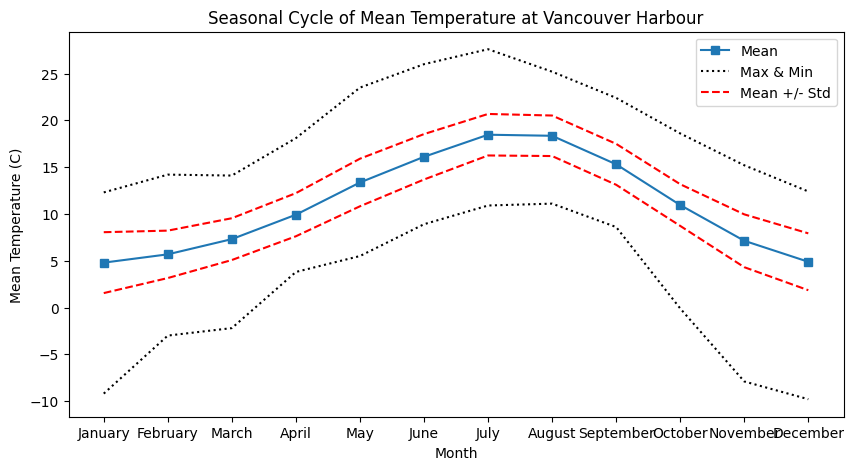

In [149]:

def find_seasonal_cycle(df, x_name, y_name, title, xlabel, ylabel):
    # Group by month and calculate mean, max, min, and std for each month
    df_monthly = df.groupby(df[x_name].dt.month).agg({y_name: ['mean', 'max', 'min', 'std']}).reset_index()

    # Rename columns and convert month number to month name
    df_monthly.columns = ['Month', 'Mean', 'Max', 'Min', 'Std']
    df_monthly['Month'] = df_monthly['Month'].apply(lambda x: datetime.date(1900, x, 1).strftime('%B'))

    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.plot(df_monthly['Month'], df_monthly['Mean'], marker='s', label='Mean')
    plt.plot(df_monthly['Month'], df_monthly['Min'], ':', color='black', label='_nolegend_')
    plt.plot(df_monthly['Month'], df_monthly['Max'], ':', color='black', label='Max & Min')
    plt.plot(df_monthly['Month'], df_monthly['Mean'] + df_monthly['Std'], '--', color='red', label='Mean +/- Std')
    plt.plot(df_monthly['Month'], df_monthly['Mean'] - df_monthly['Std'], '--', color='red', label='_nolegend_')
    
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Show the plot
    plt.show()
    return df_monthly


slev_cycle = find_seasonal_cycle(df_SOB_van, 'Date', 'sealevel', 'Seasonal Cycle of Sea Level at ' + stationName, 'Month', 'Sea Level (m)')
temp_cycle = find_seasonal_cycle(df_SOB_van, 'Date', 'MeanTemp', 'Seasonal Cycle of Mean Temperature at ' + stationName, 'Month', 'Mean Temperature (C)')

Index(['sealevel', 'MeanTemp'], dtype='object')


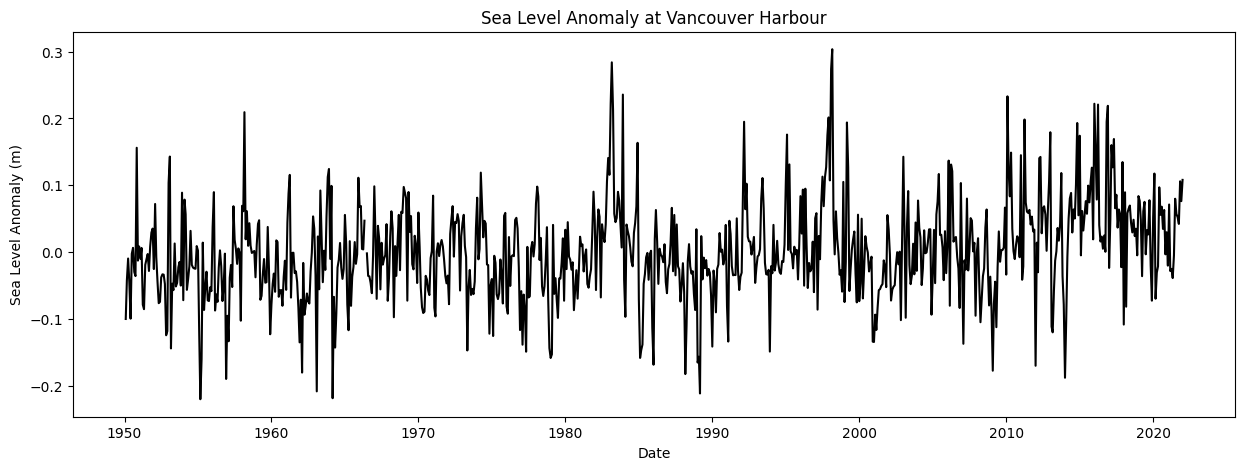

In [150]:
def plot_data_anomaly(df, x, y, title, xlabel, ylabel, cycle):
    df_monthly = df.groupby(pd.Grouper(key=x, freq='M')).mean()
    tiled_data = np.tile(cycle, 82)
    new = df_monthly[y] - tiled_data
    plt.figure(figsize=(15, 5))
    print(df_monthly.columns)
    plt.plot(df_monthly.index, new, '-', color='black' )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

    

plot_data_anomaly(df_SOB_van, 'Date', 'sealevel', 'Sea Level Anomaly at ' + stationName, 'Date', 'Sea Level Anomaly (m)', slev_cycle['Mean'])


Text(0.5, 1.0, 'Mean Monthly Temperature Anomaly Time Series at Vancouver Harbour (1940-2022)')

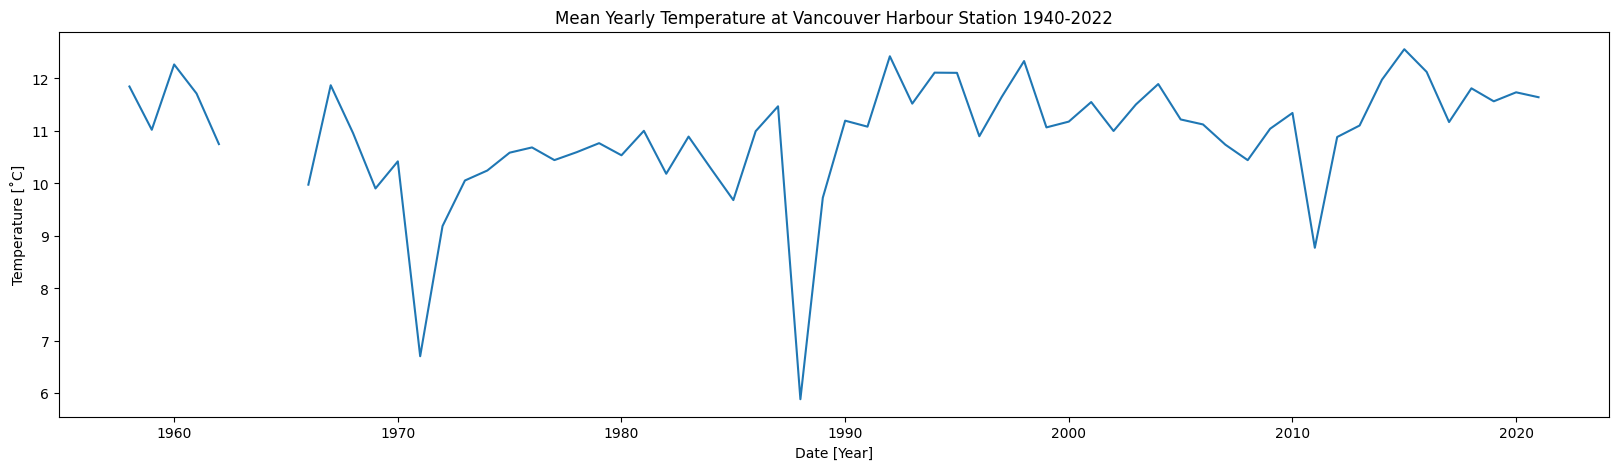

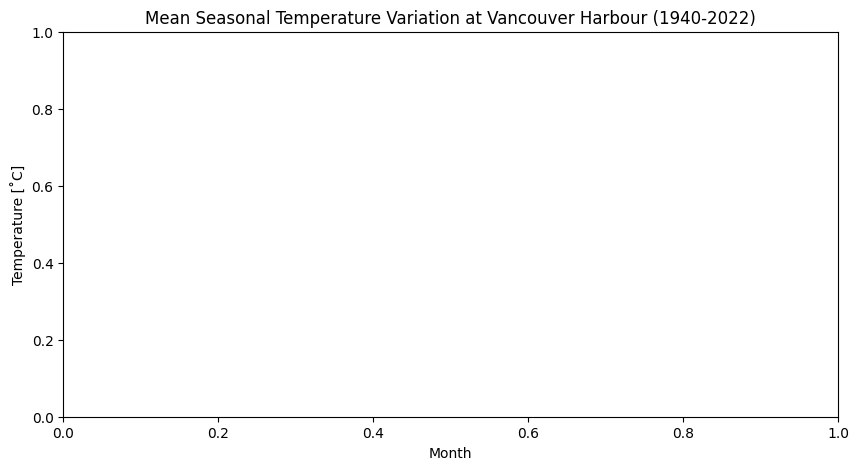

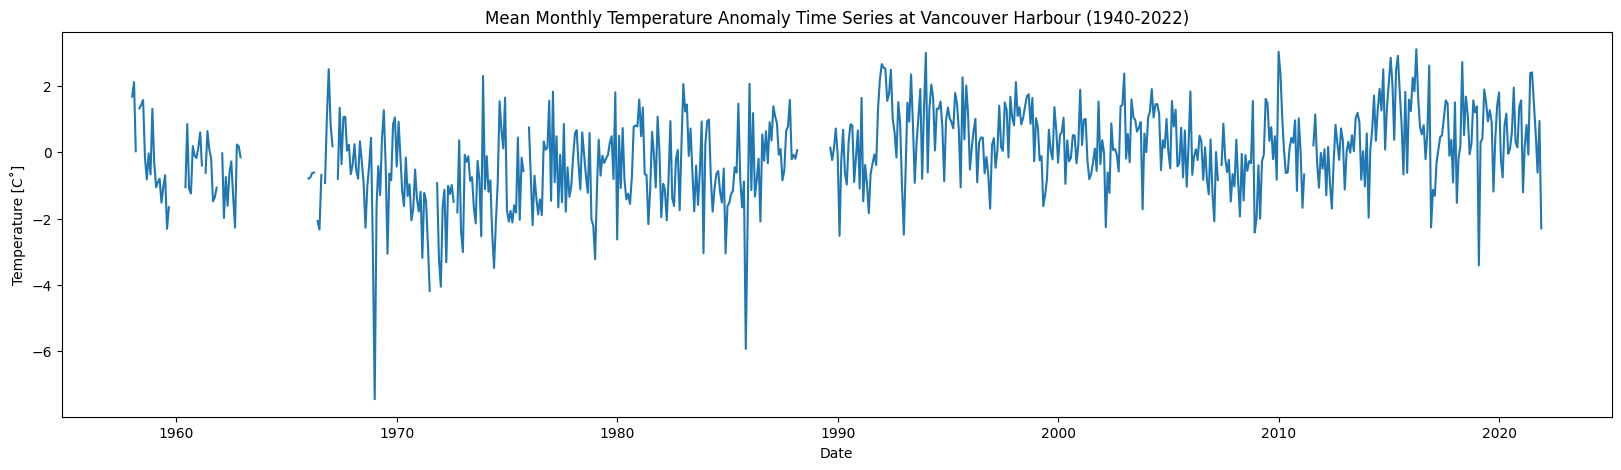

In [153]:
tempDataDF = pd.read_csv(van_temperature_file_name, sep=',', parse_dates=['Date'])

figsizes = [20,5]

########## Mean Monthly:
groupByDF2_monthly = tempDataDF.groupby(pd.PeriodIndex(tempDataDF.Date.dt.to_period('M')))["MeanTemp"] # JH: Group data by month over 1959-2018

original_monthly_temp_mean = groupByDF2_monthly.mean() # JH: Get group's mean
monthly_temp_mean = original_monthly_temp_mean.to_frame() # JH: Have to make it a dataframe to use function below
monthly_temp_mean = monthly_temp_mean.reset_index() # JH: Fix things behind the scenes silly python
monthly_dates_full = monthly_temp_mean["Date"].dt.to_timestamp() # JH: Get the x values which is all of the months



########## Mean Yearly:
groupByDF2_yearly = tempDataDF.groupby(pd.PeriodIndex(tempDataDF.Date.dt.to_period('Y')))["MeanTemp"] # JH: Group data by month over 1959-2018

original_yearly_temp_mean = groupByDF2_yearly.mean() # JH: Get group's mean
yearly_temp_mean = original_yearly_temp_mean.to_frame() # JH: Have to make it a dataframe to use function below
yearly_temp_mean = yearly_temp_mean.reset_index() # JH: Fix things behind the scenes silly python
yearly_dates_full = yearly_temp_mean["Date"].dt.to_timestamp() # JH: Get the x values which is all of the months

fYear = plt.figure(figsize=figsizes)
plt.plot(yearly_dates_full, yearly_temp_mean["MeanTemp"])
plt.title('Mean Yearly Temperature at Vancouver Harbour Station 1940-2022')
plt.xlabel('Date [Year]', fontsize=10)
plt.ylabel('Temperature [˚C]', fontsize=10)
# fYear.savefig("MeanYearlyTemp.pdf", bbox_inches='tight')


########## Lab called it: "Mean Monthly Temperature Record at Bella Bella Station 1959-2018":
monthly_mean_temp = tempDataDF.groupby(tempDataDF.Date.dt.month)["MeanTemp"].mean()
monthly_max_temp = tempDataDF.groupby(tempDataDF.Date.dt.month)["MeanTemp"].max()
monthly_min_temp = tempDataDF.groupby(tempDataDF.Date.dt.month)["MeanTemp"].min()
monthly_std_temp = tempDataDF.groupby(tempDataDF.Date.dt.month)["MeanTemp"].std()
plt.figure(figsize=(10, 5))

plt.xlabel('Month')
plt.ylabel('Temperature [˚C]')
plt.title('Mean Seasonal Temperature Variation at ' + stationName + ' (1940-2022)')


########## Anomaly time series: Lab called it: 'Mean Monthly Temperature Anomaly Time-Series at Bella Bella Station 1959-2018'
tiled_mean_temp = np.tile(monthly_mean_temp, 72)
plt.figure(figsize=(20,5))

temp_anomaly_data = monthly_temp_mean["MeanTemp"] - tiled_mean_temp
plt.plot(monthly_dates_full, temp_anomaly_data)
plt.xlabel('Date')
plt.ylabel('Temperature [C˚]')
plt.title('Mean Monthly Temperature Anomaly Time Series at ' + stationName + ' (1940-2022)')



In [152]:
def plot_correlation(x, y, title, xlabel, ylabel):
    x = x.values.reshape(-1,1) # reshape the data to be 2D
    y = y.values.reshape(-1,1)
    
    mask = np.isnan(x) | np.isnan(y) # create a mask for NaN values
    x = x[~mask] # drop the NaN values
    y = y[~mask]

    x = x.reshape(-1,1) # reshape array again?
    y = y.reshape(-1,1)
    model = LinearRegression() # create the model
    model.fit(x, y) # fit the model
    ypred = model.predict(x) # make predictions
    # plot on the same figure

    # The coefficients
    print('Coefficients: \', model.coef_')
    # The mean squared error
    # print r^2 value
    print('R^2: ', r2_score(y, ypred))

    plt.figure(figsize=(20,5))
    plt.scatter(x, y)
    plt.plot(x, ypred, color='red')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)

plot_correlation(x, y, 'Sea Level Anomaly vs Temperature Anomaly at' + stationName + '(1950-2021)', 'Temperature Anomaly [˚C]', 'Sea Level Anomaly [m]')

plot_correlation(x, y, 'Sea Level Anomaly vs Temperature Anomaly at' + stationName + '(1950-2021)', 'Temperature Anomaly [˚C]', 'Sea Level Anomaly [m]')

AttributeError: 'numpy.ndarray' object has no attribute 'values'